In [2]:
import glob, os, sys, vcf
import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, Ridge, RidgeCV
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
plt.rcParams["figure.dpi"] = 150
import scipy.stats as st

# Extracting and analyzing data from the VCF files

## Don't need to do any QC filtering because that's for reads from FASTQ files

## These are all post-QC sequences in FASTA files

```bash
bash snp_calling/call_snps.sh sequences/genome/AY988601.1_BGD_CDS.fasta seq_for_analysis/P_whitmer_BGD.fasta alignments P_whitmer_BGD
```

In [3]:
# get all the Bangladesh isolates with clade annotations
P_whitmer = [(seq.id, list(str(seq.seq))) for seq in SeqIO.parse("seq_for_analysis/P_whitmer_BGD.fasta", "fasta")]

names, seqs = list(zip(*P_whitmer))
seq_df = pd.DataFrame({"Pos": np.arange(2130)+1})
seq_df = pd.concat([seq_df, pd.DataFrame(seqs).T], axis=1)

seq_df.columns = ["Pos"] + list(names)

In [3]:
def get_aln_snps(fName):
    '''
    This function gets all the SNPs present in an alignment. 
    '''
    
    if "G_" in fName:
        chrom = "gene=G"
        protein = "G"
    elif "P_" in fName:
        chrom = "gene=P"
        protein = "P"
    
    pos = []
    ref = []
    alt = []    
    
    vcf_reader = vcf.Reader(open(fName, 'r'))

    for record in vcf_reader:
        
        # check that all variants are coming from the correct gene. Might be overkill, but just another sanity check
        if chrom not in record.CHROM or record.CHROM != chrom:
            raise ValueError(f"SNP found outside of {chrom}")
            
        # convert form VCF objects to strings to do string comparison
        alt_alleles = [str(char) for char in record.ALT]

        if "<*>" in alt_alleles:
            alt_alleles.remove("<*>")
        alt_alleles = "".join(alt_alleles)
            
        pos.append(record.POS)
        ref.append(record.REF)
        alt.append(alt_alleles)
        
    return pd.DataFrame({"pos": pos, "ref": ref, "alt": alt})

In [4]:
def get_seq_df(fasta_file, isolates_lst):
    
    seqs = [(seq.id, str(seq.seq)) for seq in SeqIO.parse(fasta_file, "fasta") if seq.id in isolates_lst]
    seq_df = pd.DataFrame(seqs).rename(columns={0:"ID", 1:"Seq"})
    
    data_transf = seq_df.Seq.str.split("", expand=True).iloc[:, 1:-1].T.reset_index()
    data_transf.columns = ["Pos"] + list(seq_df.ID.values)
    
    return data_transf

In [5]:
def create_snp_matrix(fasta_file, isolates_lst, vcf_file):
    
    seq_df = get_seq_df(fasta_file, isolates_lst)
    vcf_df = get_aln_snps(vcf_file)
    
    # search for only sites that have been flagged as having SNPs using the variant caller (using bcftools, done earlier)
    variants_seq_df = seq_df.loc[seq_df.Pos.isin(vcf_df.pos.values)]
    
    # iterate through the positions in the above dataframe
    for pos in variants_seq_df.Pos.values:
    
        # iterate through every isolate (columns)
        for col in variants_seq_df.columns[1:]:

            if variants_seq_df.loc[variants_seq_df.Pos == pos, col].values[0] == vcf_df.loc[vcf_df.pos == pos, "ref"].values[0]:
                variants_seq_df.loc[variants_seq_df.Pos == pos, col] = 0
            else:
                variants_seq_df.loc[variants_seq_df.Pos == pos, col] = 1
              
    # separate the sites
    sites = variants_seq_df.Pos.values
    del variants_seq_df["Pos"]
    
    variants_seq_df = variants_seq_df.T
    variants_seq_df.columns = sites
                
    return sites, variants_seq_df

In [6]:
metadata = pd.read_csv("metadata_all.csv")

isolates_for_model = metadata.query("G == 1 & P == 1 & Country in ['India', 'Bangladesh', 'Malaysia']").ID.values
len(isolates_for_model)

P_snp_sites, P_snp_matrix = create_snp_matrix("sequences/PG/P_seqs.fasta", isolates_for_model, "alignments/P_for_linReg_SNPs.vcf")
G_snp_sites, G_snp_matrix = create_snp_matrix("sequences/PG/G_seqs.fasta", isolates_for_model, "alignments/G_for_linReg_SNPs.vcf")

P_snp_matrix.columns = ["P" + str(col) for col in P_snp_matrix.columns]
G_snp_matrix.columns = ["G" + str(col) for col in G_snp_matrix.columns]

input_mat = pd.concat([P_snp_matrix, G_snp_matrix], axis=1)
input_mat = input_mat.astype(int)
snp_cols = input_mat.columns
isolates = input_mat.index

In [36]:
# check that it's in the same order
assert sum(metadata.query("ID in @isolates_for_model").ID.values != isolates_for_model) == 0

y = metadata.query("ID in @isolates_for_model").Country.map({"Malaysia": 0, "India": 1, "Bangladesh": 2}).values

#pd.DataFrame(y).rename(columns={0:"Y", 1:"I", 2:"B"}).to_csv("plsda_output.csv", index=False)

# recode with dummy variables (analogous to one-hot encoding)
#y = pd.get_dummies(y).values

In [33]:
input_mat.values.shape

(77, 183)

# Next, encode every sequence in `P_whitmer` as a binary variable representing reference (0) or alternative (1) allele

# PCA of P and G sequences to look for clade clustering

## 1. PCA for all data to check separation by country 

In [8]:
def create_seq_df(metadata):

    # read in all fasta files

    P_all = pd.DataFrame([(seq.id, str(seq.seq)) for seq in SeqIO.parse("sequences/PG/P_seqs.fasta", "fasta")]).rename(columns={0: "ID", 1:"P_seq"})
    G_all = pd.DataFrame([(seq.id, str(seq.seq)) for seq in SeqIO.parse("sequences/PG/G_seqs.fasta", "fasta")]).rename(columns={0: "ID", 1:"G_seq"})

    P_unique = [seq.id for seq in SeqIO.parse("seq_for_analysis/P_deduplicated.fasta", "fasta")]
    G_unique = [seq.id for seq in SeqIO.parse("seq_for_analysis/G_deduplicated.fasta", "fasta")]
    
    seq_df = pd.merge(P_all, G_all, how="outer")
    
    # add variables for whether a sequence is part of the deduplicated sets (deduplication done randomly because metadata not significantly different to justify selecting a particular sequence)
    seq_df["P_dedup"] = seq_df["ID"].isin(P_unique).astype(int)
    seq_df["G_dedup"] = seq_df["ID"].isin(G_unique).astype(int)
    
    return seq_df.merge(metadata, on="ID", how="outer")

In [9]:
# Mapping to use for one-hot encoding. No nucleotide = missing because already checked that there are no indels in these seque
BASE_TO_COLUMN = {'A': 0, 'C': 1, 'T': 2, 'G': 3, 'N': 4}
COLUMN_TO_BASE = {0: "A", 1: "C", 2: "T", 3: "G"}

# Get one hot vector
def get_one_hot(sequence):

    if not pd.isnull(sequence):
        seq_in_index = np.array([BASE_TO_COLUMN.get(b, b) for b in sequence])

        one_hot = np.zeros((len(sequence), 4))

        # only get the non gap sites because otherwise we get indexing errors
        ind_non_gap = np.where(seq_in_index != 4)[0]

        # Assign the found positions to 1
        one_hot[ind_non_gap, seq_in_index[ind_non_gap]] = 1

        return one_hot
    else:
        return np.nan

In [10]:
def pca_elbow(mat, n, scale=False):
     
    if scale:
        scaler = StandardScaler()
        mat = scaler.fit_transform(mat)
    
    pca = PCA(n)
    pca.fit(mat)
    
    plt.plot(np.arange(n)+1, pca.explained_variance_ratio_)
    plt.xticks(np.arange(n)+1)
    
    plt.xlabel("PC")
    plt.ylabel("Proportion of Variance Explained")
    sns.despine()
    plt.show()

In [11]:
# no need to use PCs of the GRM because we ARE looking for differences from population structure
# pca_elbow(np.cov(input_mat.values), 10)

In [12]:
def plot_PCA(snp_matrix, color_col, n_comp=2):
    '''
    Perform PCA using the SNP matrix
    '''
    
    ncbi_ids = snp_matrix.index.values
    
    scaler = StandardScaler()
    X = scaler.fit_transform(snp_matrix.values)
    
    pca_10 = PCA(n_components=10)
    pca_10.fit(X)

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].plot(np.arange(1, 11), pca_10.explained_variance_ratio_)
    
    pca = PCA(n_components=n_comp)
    X_new = pca.fit_transform(X)
    pca_df = pd.DataFrame(X_new).rename(columns=dict(zip(np.arange(n_comp), [f"PC{num}" for num in np.arange(n_comp)+1])))
    pca_df["ID"] = ncbi_ids
    
    sliced_metadata = metadata.loc[metadata.ID.isin(snp_matrix.index)]
    pca_df = pca_df.merge(sliced_metadata[["ID", "Country", "Clade"]], on="ID")
        
    sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue=color_col, alpha=0.7, s=50, ax=ax[1])
    sns.despine()
    plt.show()
    
    return X, pca_df

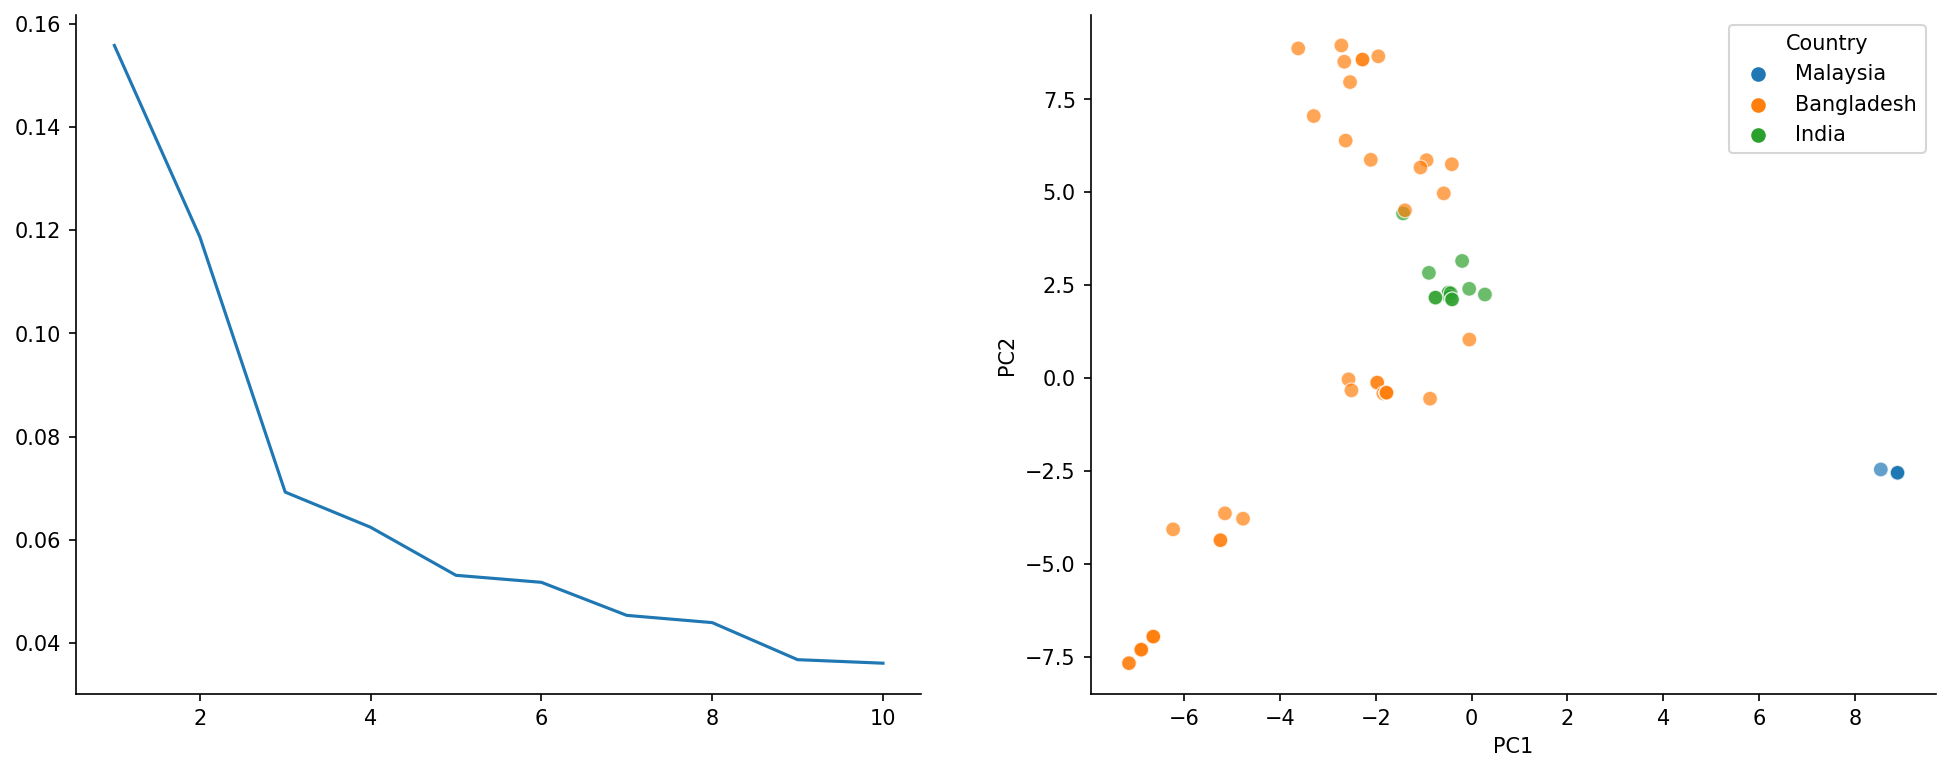

In [13]:
_, pca_df = plot_PCA(input_mat, "Country")

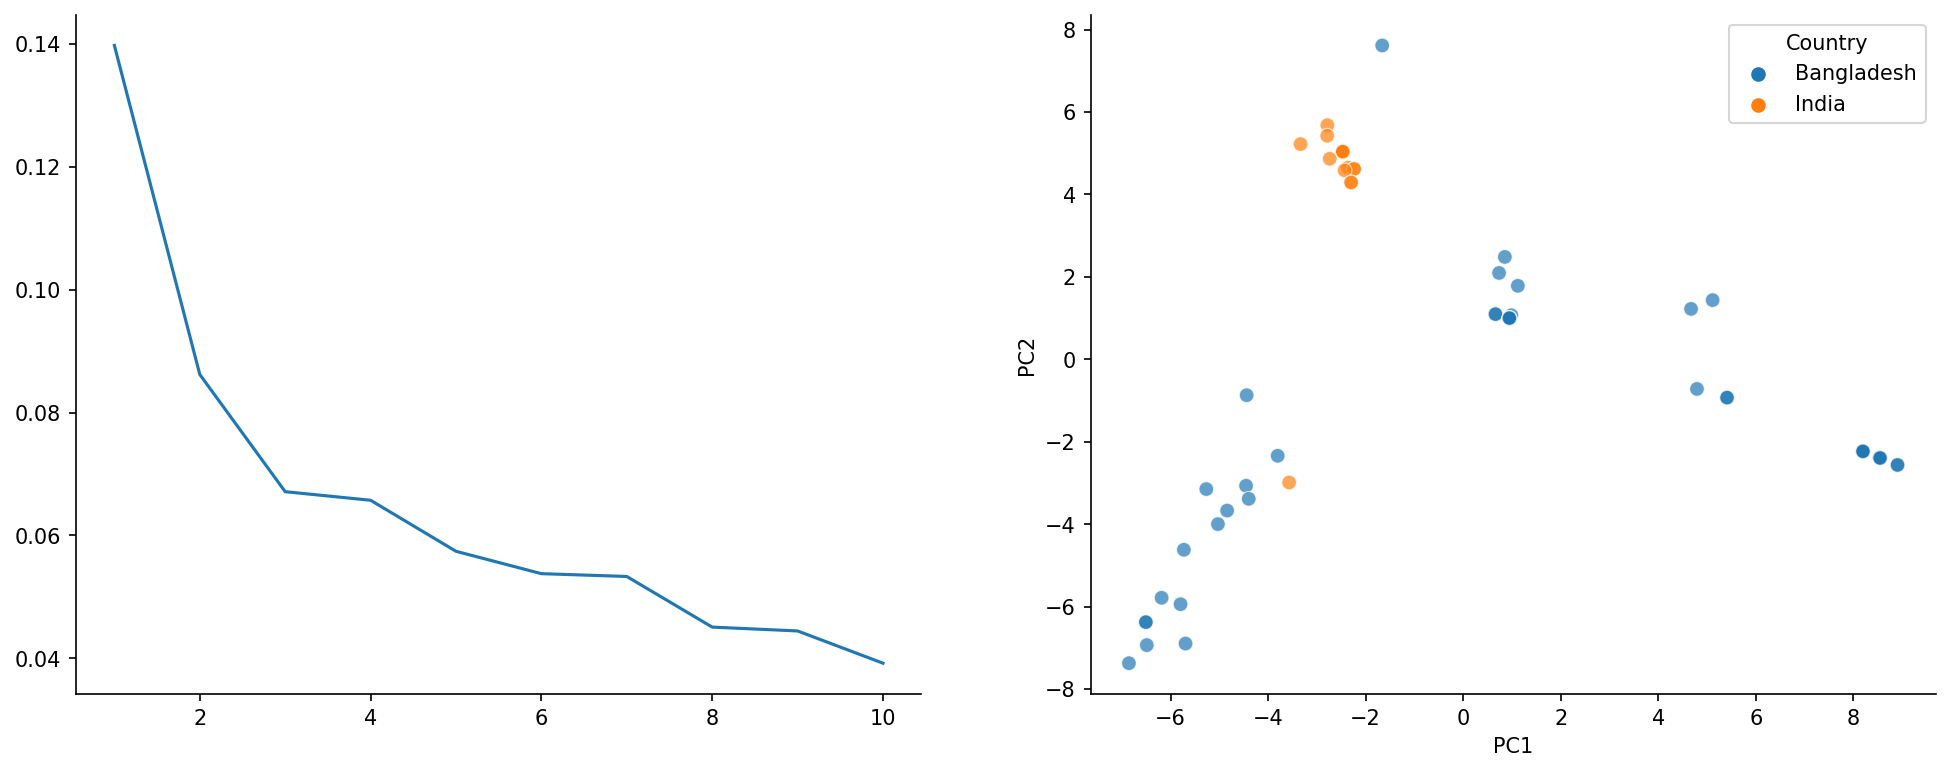

In [14]:
_, pca_df = plot_PCA(input_mat.loc[input_mat.index.isin(metadata.query("Country == 'Bangladesh' | Country == 'India'").ID)],
                     "Country", 2)

# L1/L2-Penalized Multinomial Logistic Regression

In [46]:
logistic_cv = LogisticRegressionCV(Cs=np.logspace(-3, 3, 7), 
                                   fit_intercept=True, 
                                   cv=5, 
                                   penalty='elasticnet', 
                                   #scoring='multilabel_confusion_matrix', 
                                   #scoring='precision_recall_fscore_support',
                                   #scoring='log_loss', # cross entropy function for crossentropy
                                   scoring='f1_weighted',
                                   solver='saga', 
                                   max_iter=10000, 
                                   class_weight='balanced', 
                                   multi_class='multinomial',
                                   l1_ratios=np.linspace(0, 1, 11)
                                  )

In [47]:
scaler = StandardScaler()
X = scaler.fit_transform(input_mat.values)
logistic_cv.fit(X, y)

LogisticRegressionCV(Cs=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                     class_weight='balanced', cv=5,
                     l1_ratios=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                     max_iter=10000, multi_class='multinomial',
                     penalty='elasticnet', scoring='f1_weighted',
                     solver='saga')

In [48]:
logistic_cv.l1_ratio_

array([0.1, 0.1, 0.1])

In [49]:
logistic_cv.C_

array([0.01, 0.01, 0.01])

In [59]:
logistic = LogisticRegression(penalty='elasticnet', 
                              l1_ratio=0.1,
                              C=0.01,
                              fit_intercept=True,
                              solver='saga',
                              max_iter=10000,
                              multi_class='multinomial'
                             )

logistic.fit(X, y)

LogisticRegression(C=0.01, l1_ratio=0.1, max_iter=10000,
                   multi_class='multinomial', penalty='elasticnet',
                   solver='saga')

In [63]:
logistic.coef_.shape

(3, 183)

In [64]:
logistic.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [65]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [66]:
logistic.score(X, y)

0.987012987012987

In [91]:
logistic_feat_df = pd.DataFrame(logistic.coef_).T
logistic_feat_df.columns = ["Malaysia", "India", "Bangladesh"]
logistic_feat_df.index = logistic_feat_df.index.rename("Feature")
logistic_feat_df = logistic_feat_df.set_index(input_mat.columns)

In [92]:
logistic_feat_df

,Malaysia,India,Bangladesh
P99,0.000000,0.000000,0.00000
P167,0.000000,0.000000,0.00000
P175,0.000000,0.000000,0.00000
P181,0.000000,0.000000,0.00000
P190,0.000000,0.000000,0.00296
...,...,...,...
G1656,0.000000,0.015679,0.00000
G1659,0.044424,0.000000,0.00000
G1706,0.000000,0.000000,0.00000
G1746,0.000000,0.000000,0.00000


In [95]:
np.log(0.05/(1-0.05))

-2.9444389791664403

In [93]:
logistic_feat_df.query("Malaysia != 0")

,Malaysia,India,Bangladesh
P415,0.047728,0.0,0.000000
P893,0.047728,0.0,0.000000
P899,0.012956,0.0,0.000000
P1041,0.031142,0.0,0.000000
P1095,0.048547,0.0,0.000000
P1138,0.048406,0.0,0.000000
P1173,0.026242,0.0,0.000000
P1209,0.036604,0.0,0.000000
P1683,0.048295,0.0,0.000000
P1926,0.048406,0.0,0.000000


In [97]:
logistic_feat_df.query("India != 0 & Bangladesh != 0")

,Malaysia,India,Bangladesh
P813,0.0,0.090608,-0.029693
P1099,0.0,0.005754,-0.094559
P1125,0.0,-0.020889,0.105969
P1162,0.0,0.006285,-0.095581
P1758,0.0,0.089758,-0.028704
P1929,0.0,0.089650,-0.027035
G1407,0.0,0.006939,-0.096332


In [98]:
logistic_feat_df.query("India != 0 | Bangladesh != 0")

,Malaysia,India,Bangladesh
P190,0.00000,0.000000,0.002960
P732,0.00000,0.034780,0.000000
P738,0.00000,0.000000,-0.016121
P813,0.00000,0.090608,-0.029693
P942,0.00000,0.000000,-0.033464
P1099,0.00000,0.005754,-0.094559
P1125,0.00000,-0.020889,0.105969
P1162,0.00000,0.006285,-0.095581
P1758,0.00000,0.089758,-0.028704
P1929,0.00000,0.089650,-0.027035


# Partial Least Squares Discriminant Analysis

In [17]:
n_comp = 2
plsda = PLSRegression(n_comp, scale=True)
plsda.fit(input_mat.values, y)
X_plsda, y_plsda = plsda.transform(input_mat.values, y)

plsda_df = pd.DataFrame(X_plsda).rename(columns=dict(zip(np.arange(n_comp), [f"LV{num}" for num in np.arange(n_comp)+1])))
plsda_df["ID"] = isolates
plsda_df = plsda_df.merge(metadata, on="ID")

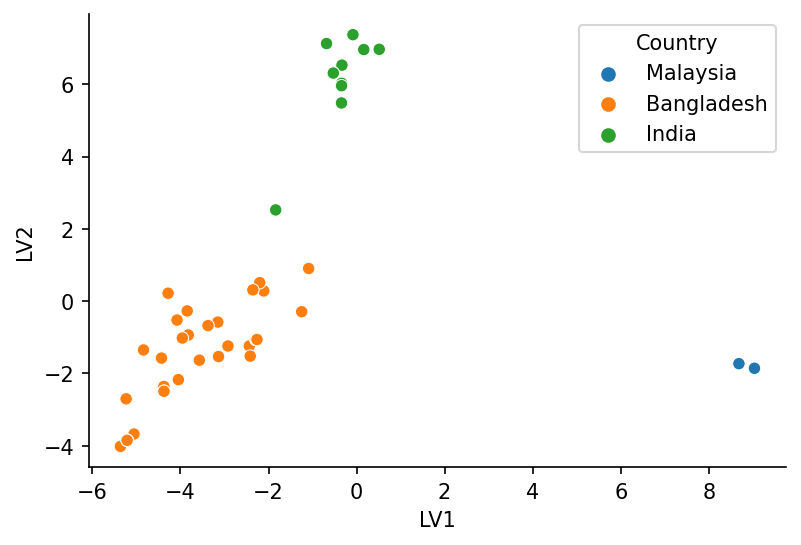

In [18]:
sns.scatterplot(data=plsda_df, x="LV1", y="LV2", hue="Country")
sns.despine()
plt.show()

In [19]:
loadings_df = pd.DataFrame(plsda.x_loadings_).rename(columns={0:"LV1", 1:"LV2"})
#loadings_df.index = snp_cols
loadings_df["feat"] = snp_cols

In [20]:
plsda.coef_.shape

(183, 3)

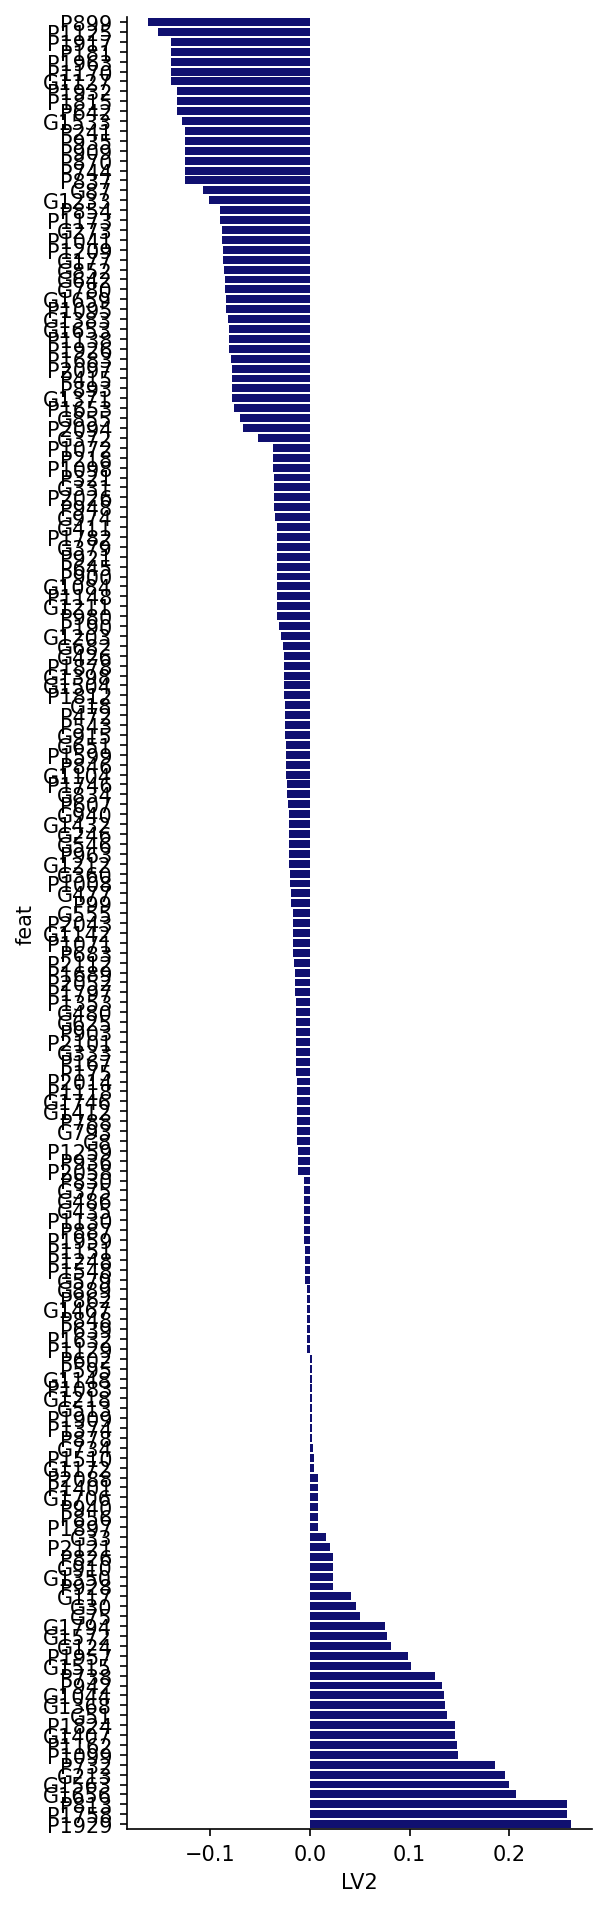

In [21]:
plt.figure(figsize=(4, 16))
sns.barplot(data=loadings_df.sort_values("LV2"), x="LV2", y="feat", color="navy")

sns.despine()
plt.show()

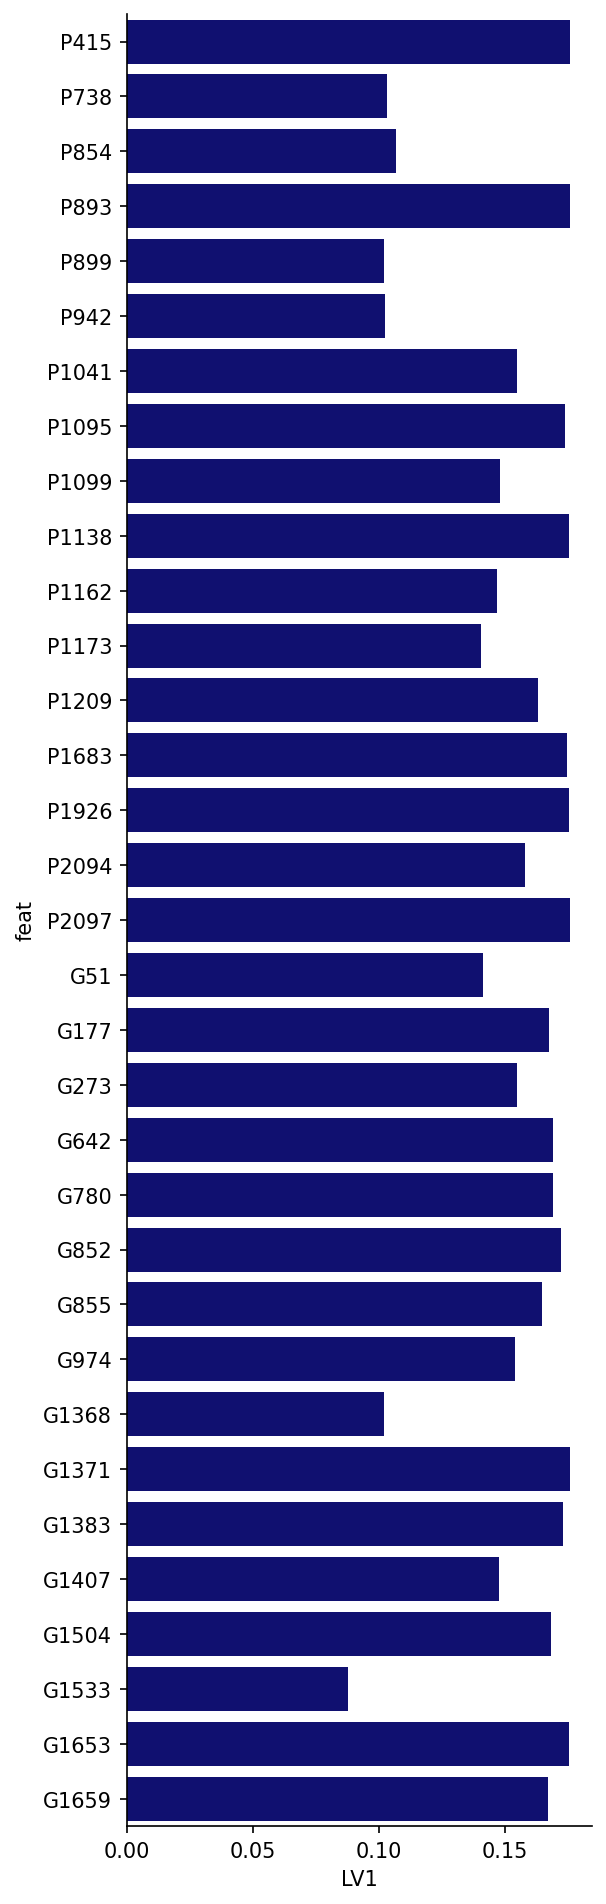

In [72]:
plt.figure(figsize=(4, 16))
sns.barplot(data=loadings_df.query("LV1 > 0"), x="LV1", y="feat", color="navy")

sns.despine()
plt.show()

/Users/skulkarni/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


<AxesSubplot:>

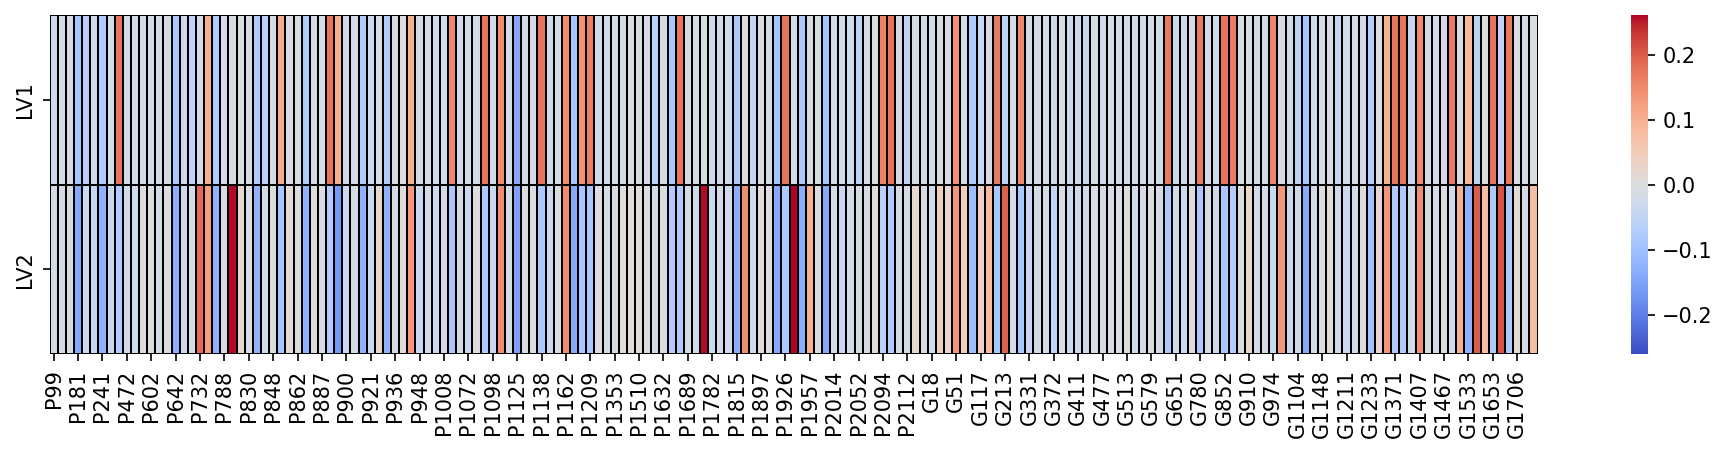

In [57]:


max_val = np.max(np.max(abs(loadings_df)))

# palette = {1:"tab:red",
#        0:"tab:gray"}

# fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)

# sns.scatterplot(data=df_res, x="LV1", y="LV2", hue="Country", 
#                 #palette=palette,
#                 palette="tab10",
#                 ax=ax[0])


plt.figure(figsize=(16, 3))
sns.heatmap(loadings_df.T, 
            vmin=-max_val, vmax=max_val, center=0,
             #cmap=sns.diverging_palette(220, 20, n=200),
             cmap=sns.color_palette("coolwarm", as_cmap=True),
            linewidth=0.1,
            linecolor="black",
             cbar=True
           )

In [36]:
feat_df = pd.DataFrame(plsda.x_loadings_).rename(columns={0:"LV1", 1:"LV2"})
feat_df["feat"] = snp_cols

In [37]:
feat_df

,LV1,LV2,feat
0,-0.027210,-0.018900,P99
1,-0.018556,-0.013852,P167
2,-0.018556,-0.013852,P175
3,-0.091878,-0.139261,P181
4,-0.061847,-0.030826,P190
...,...,...,...
178,-0.048605,0.206783,G1656
179,0.167051,-0.084191,G1659
180,-0.004512,0.008302,G1706
181,-0.020066,-0.012438,G1746


# Perform logistic regression to separate the Bangladesh clades

## Keeping LASSO here only to show that regularization parameter approaches 0

In [42]:
# get eigenvalues as additional inputs
pca = PCA(3)
pca.fit(np.cov(input_mat.values))
eigenvec = pca.components_.T

X = np.concatenate([input_mat.values, eigenvec], axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

lasso_cv = LogisticRegressionCV(penalty='l1', 
                                Cs=1/np.logspace(-10, 10, 1000), 
                                solver="saga", 
                                cv=5, 
                                multi_class='multinomial',
                                max_iter=100000)
lasso_cv.fit(X, y)

lasso = LogisticRegression(C=lasso_cv.C_[0])
print(f"Fitting Lasso with alpha = {1/lasso_cv.C_[0]}")
lasso.fit(X, y)

lasso_coef = np.squeeze(lasso.coef_)

coef_df = pd.DataFrame({"pos": list(snp_cols) + [f"PC_{str(num)}" for num in range(3)], 
                        "M_coef": lasso_coef[0], 
                        "I_coef": lasso_coef[1], 
                        "B_coef": lasso_coef[2]})

Fitting Lasso with alpha = 0.017711210643450905


In [47]:
coef_df.sort_values("M_coef", ascending=False)

,pos,M_coef,I_coef,B_coef
144,G852,0.170539,-0.074146,-0.096393
166,G1383,0.170056,-0.078309,-0.091747
53,P1095,0.169970,-0.075864,-0.094107
77,P1683,0.167528,-0.092695,-0.074833
8,P415,0.166340,-0.086632,-0.079708
...,...,...,...,...
22,P813,-0.068614,0.367461,-0.298847
91,P1929,-0.072302,0.359076,-0.286774
178,G1656,-0.079506,0.214339,-0.134833
117,G213,-0.086870,0.195496,-0.108626


In [201]:
# building the model and fitting the data
#log_reg = sm.Logit((pca_df_bgd.Clade == "B-1").astype(int), X_snps_bgd).fit()

# Looked for natural breaks in the coefficient magnitudes

## B-1 clade: 1746, 1041
## B-2 clade: 190, 738, 1599, 846, 942, 854